In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy

import gym
from gym import spaces
from gym.utils import seeding

In [2]:
class PID:
    def __init__(self, p=5, i=0.1, d=1):
        self.p = p
        self.i = i
        self.d = d
        self.i_value = 0

    def control(self, e, e_d):
        '''
        This function calculates control output
        @params:
            e: angular error
            e_d: angular velocity error
        '''
        self.i_value += e
        self.i_value = np.clip(self.i_value, -10000, 10000)
        return self.p * e + self.i * self.i_value + self.d * e_d

# linear model

In [30]:
class Pendulum_PID_Env(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}
    '''
    only PID integrated environment
    '''
    def __init__(self):
        self.M = .5
        self.m = 0.2
        self.F0 = 0.1
        self.F1 = 0.1
        self.I = 0.006
        self.g = 9.8
        self.l = 0.3
        self.dt = 0.01

        high = np.array([np.pi/3, 10, np.pi/3, 10], dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([-30], dtype=np.float32), high=np.array([30], dtype=np.float32), shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def normalize(self, x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi


    def step(self, PID1_param=[52.49,0,7.485], PID2_param=[129.7,0,11.75], target=[0,0]):
        '''
        @param:
            PID1_param, PID2_param: baseline parameters for 2 PIDs
        '''
        # initialization
        x, x_d, phi, phi_d = self.state  # retrieve info of the actuator link

        M = self.M
        m = self.m
        F0 = self.F0
        F1 = self.F1
        I = self.I
        g = self.g
        l = self.l
        kp1 = PID1_param[0]
        kd1 = PID1_param[2]
        kp2 = PID2_param[0]
        kd2 = PID2_param[2]
        
        p = I*(M+m)+M*m*l**2 # denominator for the A and B matrices
        A = (M+m)*m*g*l/p
        B = -F1*(M+m)/p
        C = F0*m*l/p
        D = -m*l/p
        E = -m*m*g*l*l/p
        F = F1*m*l/p
        G = -F0*(I+m*l*l)/p
        H = (I+m*l*l)/p
        
        
        e1 = target[0] - phi
        e2 = target[1] - phi_d

        x_d_r = ( kp1*e1+kd1*e2-A*phi-B*phi_d+E*D/H*phi+F*D/H*phi_d+G*D/H*x_d+D/H*kd2*x_d) / (C + D/H*kp2*self.dt)
        u = -E/H*phi -F/H*phi_d-G/H*x_d +(kp2*self.dt)*x_d_r/H -kd2/H*x_d


        # acceleration calculation
        
        phi_dd = A * phi + B * phi_d + C * x_d + D * u
        x_dd = E * phi + F * phi_d + G * x_d + H * u

        # semi-implicit euler
        for _ in range(1):
            x += self.dt * x_d / 1
            x_d += self.dt * x_dd / 1
            x = np.clip(x, -100, 100)
            x_d = np.clip(x_d, -100, 100)

            phi += self.dt * phi_d / 1
            phi_d += self.dt * phi_dd / 1
            phi_d = np.clip(phi_d, -100, 100)
            phi = self.normalize(phi)
        
            
            
        ############## cost ####################
        costs = self.normalize(phi) ** 2 + 0.1 * phi_d**2 + 0.00 * x**2 # + 0.001 * (u**2)

        # Output
        self.state = np.array([float(x), float(x_d), float(phi), float(phi_d)])

        return self._get_obs(), -float(costs), False, {'x_d_r':x_d_r, 'u':u}

    def reset(self):
        # always reset all to 0
        high = np.array([np.pi/2, 10, np.pi/2, 10], dtype=np.float32)
        self.state = self.np_random.uniform(low=-high, high=high)
        self.state = np.array([0, 0, 0.5, 0], dtype=np.float32)
        return self.state

    def _get_obs(self):
        # we can only observe the angle of the actuator
        x, x_d, phi, phi_d = self.state
        return np.array([x, x_d, phi, phi_d], dtype=np.float32)

# testing

In [79]:
phi_l = []
phi_d_l = []
x_l = []
x_d_l = []
x_d_r_l = []
u_l = []

def episode_run(x1, x2, x3, x4):
    env = Pendulum_PID_Env()
    reward_episode = 0
    

    # Number of steps you run the agent for 
    num_steps = 800
    obs = env.reset()
    
    phi_l.append(obs[2])
    x_l.append(obs[0])
    x_d_r_l.append(0)
    x_d_l.append(obs[1])
    phi_d_l.append(obs[3])
    u_l.append(0)


    ################## simulation
    for step in range(num_steps):

        # apply the action
        obs, reward, done, info = env.step([x1, 0, x2], [x3, 0, x4])

        phi_l.append(obs[2])
        x_l.append(obs[0])
        x_d_r_l.append(info['x_d_r'])
        u_l.append(info['u'])
        x_d_l.append(obs[1])
        phi_d_l.append(obs[3])
        
        reward_episode += reward
        
        
        # If the epsiode is up, then start another one
        if done:
            env.reset()

    # Close the env
    env.close()
    return reward_episode

In [80]:
episode_run(133.8,46.67,82.17,80.336)

-39.974345046656474

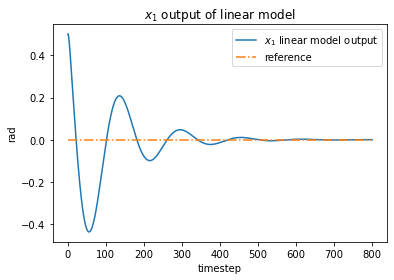

In [81]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(phi_l, label='$x_1$ linear model output') # -7.499676092201453
ax.plot([0]*len(phi_l), linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_1$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('rad')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x1linear.png", dpi=500, format="png")

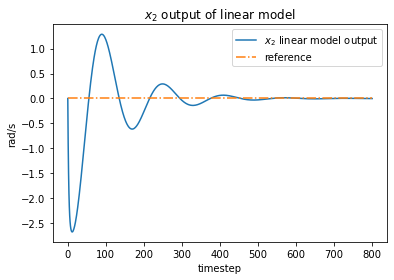

In [82]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(phi_d_l, label='$x_2$ linear model output') # -7.499676092201453
ax.plot([0]*len(x_d_l), linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_2$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('rad/s')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x2linear.png", dpi=500, format="png")

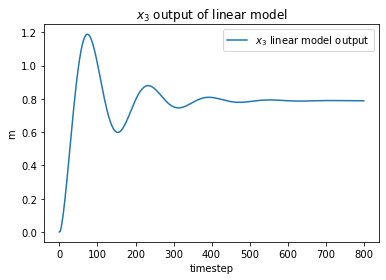

In [83]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_l, label='$x_3$ linear model output') # -7.499676092201453
# ax.plot([0]*len(x_d_l), linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_3$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('m')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x3linear.png", dpi=500, format="png")

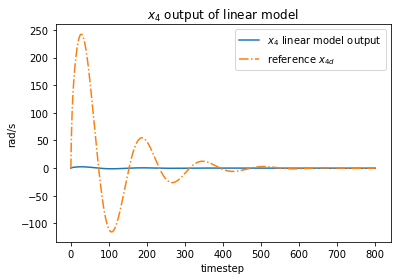

In [84]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_d_l, label='$x_4$ linear model output') # -7.499676092201453
ax.plot(x_d_r_l, linestyle="-.", label='reference $x_{4d}$') # -8.540721246923548

plt.title('$x_4$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('rad/s')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x4linear.png", dpi=500, format="png")

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_36664/2926230459.py:3: RuntimeWarning: invalid value encountered in true_divide
  ax.plot((np.array(x_d_l)*1000)/(np.array(x_d_r_l)*1000), label='$x_4:x_{4d}$ linear model output') # -7.499676092201453


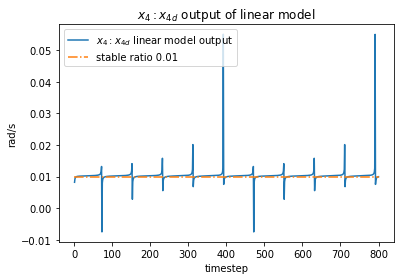

In [85]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot((np.array(x_d_l)*1000)/(np.array(x_d_r_l)*1000), label='$x_4:x_{4d}$ linear model output') # -7.499676092201453
ax.plot([0.01]*len(x_d_l), linestyle="-.", label='stable ratio 0.01')
plt.title('$x_4:x_{4d}$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('rad/s')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x4x4dlinear.png", dpi=500, format="png")

In [87]:
(np.array(x_d_l)*1000)/(np.array(x_d_r_l)*1000)

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_36664/2340454249.py:1: RuntimeWarning: invalid value encountered in true_divide
  (np.array(x_d_l)*1000)/(np.array(x_d_r_l)*1000)


array([        nan,  0.008217  ,  0.00925993,  0.00964333,  0.00983074,
        0.00993616,  0.01000099,  0.01004365,  0.01007339,  0.01009522,
        0.01011202,  0.0101255 ,  0.01013673,  0.01014637,  0.01015485,
        0.01016246,  0.01016941,  0.01017583,  0.01018182,  0.01018746,
        0.0101928 ,  0.01019789,  0.01020277,  0.01020747,  0.01021201,
        0.01021642,  0.01022072,  0.01022492,  0.01022904,  0.0102331 ,
        0.0102371 ,  0.01024107,  0.01024502,  0.01024895,  0.01025289,
        0.01025683,  0.01026081,  0.01026482,  0.01026888,  0.010273  ,
        0.01027721,  0.01028151,  0.01028592,  0.01029046,  0.01029516,
        0.01030003,  0.0103051 ,  0.01031041,  0.01031597,  0.01032184,
        0.01032806,  0.01033468,  0.01034176,  0.01034939,  0.01035764,
        0.01036663,  0.0103765 ,  0.01038742,  0.0103996 ,  0.01041332,
        0.01042895,  0.01044696,  0.01046803,  0.01049309,  0.0105235 ,
        0.01056129,  0.01060972,  0.01067421,  0.01076472,  0.01

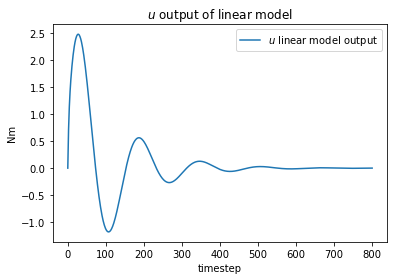

In [37]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_d_l, label='$u$ linear model output') # -7.499676092201453
# ax.plot(x_d_r_l, linestyle="-.", label='reference $x_{4d}$') # -8.540721246923548

plt.title('$u$ output of linear model')
plt.xlabel('timestep')
plt.ylabel('Nm')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/ulinear.png", dpi=500, format="png")

# BO for linear

In [433]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'x1': (0, 200), 'x2': (0, 50), \
           'x3': (0, 200), 'x4': (0, 50)}
optimizer = BayesianOptimization(
    f=episode_run,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=50,
    n_iter=100,
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |
-------------------------------------------------------------------------
|  3        | -25.15    |  79.35    |  26.94    |  83.84    |  34.26    |
|  5        | -18.55    |  83.46    |  27.93    |  28.08    |  9.905    |
|  6        | -16.81    |  160.1    |  48.41    |  62.68    |  34.62    |
|  9        | -14.09    |  191.6    |  26.66    |  138.4    |  15.78    |


KeyboardInterrupt: 

## Nonlinear

In [63]:
class Nonlinear_Pendulum_PID_Env(gym.Env):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": 30}
    '''
    only PID integrated environment
    '''
    def __init__(self):
        self.M = .5
        self.m = 0.2
        self.F0 = 0.1
        self.F1 = 0.1
        self.J = 0.006
        self.g = 9.8
        self.l = 0.3
        self.dt = 0.01

        high = np.array([np.pi/3, 10, np.pi/3, 10], dtype=np.float32)
        self.action_space = spaces.Box(
            low=np.array([-30], dtype=np.float32), high=np.array([30], dtype=np.float32), shape=(1,), dtype=np.float32
        )
        self.observation_space = spaces.Box(low=-high, high=high, dtype=np.float32)

        self.seed(0)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def normalize(self, x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi


    def step(self, PID1_param=[52.49,0,7.485], PID2_param=[129.7,0,11.75], target=[0,0]):
        '''
        @param:
            PID1_param, PID2_param: baseline parameters for 2 PIDs
        '''
        # initialization
        x, x_d, phi, phi_d = self.state  # retrieve info of the actuator link

        M = self.M
        m = self.m
        F0 = self.F0
        F1 = self.F1
        J = self.J
        g = self.g
        l = self.l
        dt = self.dt
        
        kp1 = PID1_param[0]
        kd1 = PID1_param[2]
        kp2 = PID2_param[0]
        kd2 = PID2_param[2]
        
        p = (M+m)*(J+m*l**2) - m**2*l**2*np.cos(phi)**2 # denominator for the A and B matrices
        
        
        e1 = target[0] - phi
        e2 = target[1] - phi_d
        x_d_r = p*(kp1*e1+kd1*e2) + F1*(M+m)*phi_d + m*m*l*l*phi_d*phi_d*np.sin(phi)*np.cos(phi) - (M+m)*m*g*l*np.sin(phi) # - F0*m*l*np.cos(phi)*x_d
        x_d_r += m*l*np.cos(phi)/(J+m*l*l) * (-F1*m*l*phi_d*np.cos(phi) -(J+m*l*l)*m*l*phi_d**2*np.sin(phi) \
                                              +F0*(J+m*l*l)*x_d +m*m*g*l*l*np.sin(phi)*np.cos(phi))
        x_d_r -= m*l*np.cos(phi)*(p/(J+m*l*l)*kd2*x_d)
        x_d_r /= (F0*m*l*np.cos(phi)-p*m*l*np.cos(phi)*kp2*dt/(J+m*l*l))
        
        u = 1/(J+m*l*l) * (-F1*m*l*phi_d*np.cos(phi) -(J+m*l*l)*m*l*phi_d**2*np.sin(phi) \
                           +F0*(J+m*l*l)*x_d +m*m*g*l*l*np.sin(phi)*np.cos(phi))
        u += p/(J+m*l*l) * (kp2*dt*x_d_r - kd2*x_d)

        # acceleration calculation
        
        phi_dd = - F1*(M+m)*phi_d - m*m*l*l*phi_d*phi_d*np.sin(phi)*np.cos(phi) + (M+m)*m*g*l*np.sin(phi) + F0*m*l*np.cos(phi)*x_d - m*l*np.cos(phi)*u
        phi_dd /= p
        x_dd = F1*m*l*phi_d*np.cos(phi) +(J+m*l*l)*m*l*phi_d**2*np.sin(phi) -F0*(J+m*l*l)*x_d -m*m*g*l*l*np.sin(phi)*np.cos(phi) +(J+m*l*l)*u
        x_dd /= p

        # semi-implicit euler
        for _ in range(10):
            x += self.dt * x_d / 10
            x_d += self.dt * x_dd / 10
            x = np.clip(x, -100, 100)
            x_d = np.clip(x_d, -100, 100)

            phi += self.dt * phi_d / 10
            phi_d += self.dt * phi_dd / 10
            phi_d = np.clip(phi_d, -100, 100)
            phi = self.normalize(phi)
        
            
            
        ############## cost ####################
        costs = self.normalize(phi) ** 2 + 0.1 * phi_d**2 + 0.02 * x**2 # + 0.001 * (u**2)

        # Output
        self.state = np.array([float(x), float(x_d), float(phi), float(phi_d)])

        return self._get_obs(), -float(costs), False, {'x_d_r':x_d_r, 'u':u}

    def reset(self):
        # always reset all to 0
        high = np.array([np.pi/2, 10, np.pi/2, 10], dtype=np.float32)
        self.state = self.np_random.uniform(low=-high, high=high)
        self.state = np.array([0, 0, 0.5, 0], dtype=np.float32)
        return self.state

    def _get_obs(self):
        # we can only observe the angle of the actuator
        x, x_d, phi, phi_d = self.state
        return np.array([x, x_d, phi, phi_d], dtype=np.float32)

In [90]:
phi_l = []
phi_d_l = []
x_l = []
x_d_l = []
x_d_r_l = []
u_l = []

def episode_run(x1, x2, x3, x4):
    env = Nonlinear_Pendulum_PID_Env()
    reward_episode = 0
    

    # Number of steps you run the agent for 
    num_steps = 800
    obs = env.reset()
    
    phi_l.append(obs[2])
    x_l.append(obs[0])
    x_d_r_l.append(0)
    x_d_l.append(obs[1])
    phi_d_l.append(obs[3])
    u_l.append(0)


    ################## simulation
    for step in range(num_steps):

        # apply the action
        obs, reward, done, info = env.step([x1, 0, x2], [x3, 0, x4])

        phi_l.append(obs[2])
        x_l.append(obs[0])
        x_d_r_l.append(info['x_d_r'])
        u_l.append(info['u'])
        x_d_l.append(obs[1])
        phi_d_l.append(obs[3])
        
        reward_episode += reward
        
        
        # If the epsiode is up, then start another one
        if done:
            env.reset()

    # Close the env
    env.close()
    return reward_episode

In [91]:
episode_run(147.4,42.98,112.6,75.7011)

-46.37118395566061

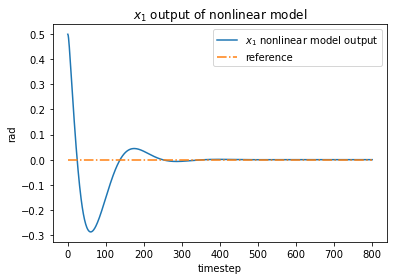

In [92]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(phi_l, label='$x_1$ nonlinear model output') # -7.499676092201453
ax.plot([0]*len(phi_l), linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_1$ output of nonlinear model')
plt.xlabel('timestep')
plt.ylabel('rad')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x1nonlinear.png", dpi=500, format="png")

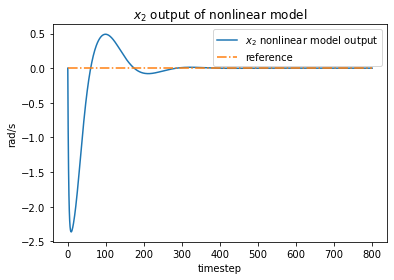

In [93]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(phi_d_l, label='$x_2$ nonlinear model output') # -7.499676092201453
ax.plot([0]*len(x_d_l), linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_2$ output of nonlinear model')
plt.xlabel('timestep')
plt.ylabel('rad/s')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x2nonlinear.png", dpi=500, format="png")

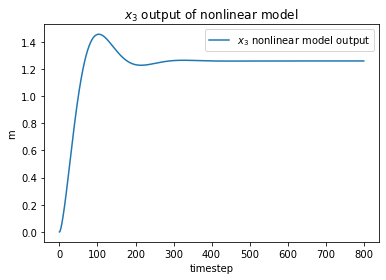

In [94]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_l, label='$x_3$ nonlinear model output') # -7.499676092201453
# ax.plot([0]*len(x_d_l), linestyle="-.", label='reference') # -8.540721246923548

plt.title('$x_3$ output of nonlinear model')
plt.xlabel('timestep')
plt.ylabel('m')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x3nonlinear.png", dpi=500, format="png")

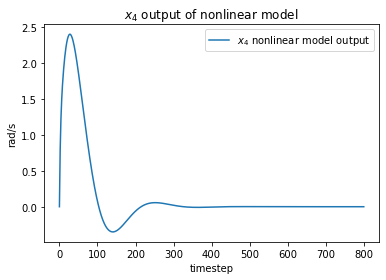

In [100]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_d_l, label='$x_4$ nonlinear model output') # -7.499676092201453
ax.plot(x_d_r_l, linestyle="-.", label='reference $x_{4d}$') # -8.540721246923548

plt.title('$x_4$ output of nonlinear model')
plt.xlabel('timestep')
plt.ylabel('rad/s')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x4nonlinear.png", dpi=500, format="png")

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_36664/1350077591.py:3: RuntimeWarning: invalid value encountered in true_divide
  ax.plot((np.array(x_d_l))/(np.array(x_d_r_l)), label='$x_4:x_{4d}$ nonlinear model output') # -7.499676092201453


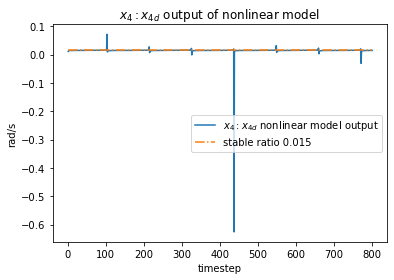

In [99]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot((np.array(x_d_l))/(np.array(x_d_r_l)), label='$x_4:x_{4d}$ nonlinear model output') # -7.499676092201453
ax.plot([0.015]*len(x_d_l), linestyle="-.", label='stable ratio 0.015')
plt.title('$x_4:x_{4d}$ output of nonlinear model')
plt.xlabel('timestep')
plt.ylabel('rad/s')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/x4x4dnonlinear.png", dpi=500, format="png")

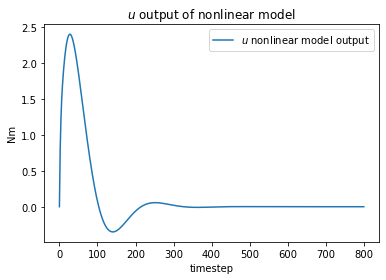

In [97]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_d_l, label='$u$ nonlinear model output') # -7.499676092201453
# ax.plot(x_d_r_l, linestyle="-.", label='reference $x_{4d}$') # -8.540721246923548

plt.title('$u$ output of nonlinear model')
plt.xlabel('timestep')
plt.ylabel('Nm')
plt.legend()
fig.savefig("C:/Users/Lenovo/Desktop/figures/unonlinear.png", dpi=500, format="png")

# BO for nonlinear

In [371]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'x1': (0, 200), 'x2': (0, 50), \
           'x3': (0, 200), 'x4': (0, 50)}
optimizer = BayesianOptimization(
    f=episode_run,
    pbounds=pbounds,
    verbose=1, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(
    init_points=50,
    n_iter=100,
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |
-------------------------------------------------------------------------
|  3        | -25.15    |  79.35    |  26.94    |  83.84    |  34.26    |
|  5        | -18.55    |  83.46    |  27.93    |  28.08    |  9.905    |
|  6        | -16.81    |  160.1    |  48.41    |  62.68    |  34.62    |
|  9        | -14.09    |  191.6    |  26.66    |  138.4    |  15.78    |
|  14       | -9.803    |  42.33    |  13.28    |  98.31    |  2.668    |
|  30       | -8.609    |  150.8    |  46.15    |  142.3    |  6.214    |
|  82       | -8.412    |  147.4    |  42.98    |  112.6    |  0.7011   |
|  133      | -8.3      |  150.7    |  50.0     |  68.09    |  0.0      |
